#### <i>Блок проекта для размещения только на Kaggle.com</i>

### Кредитный скоринг
Автор: Petrochenkov Victor
e-mail: 4941737@mail.ru

##### Задача: 
     Используя представленные данные, создать модель, с помощью которой прогнозируется возможность дефолта - невозврата заёмщиком кредита и соответственно формируется рекомендация выдавать кредит или отказать.
     Про заявителей известны различные данные на момент заполнения анкеты. По части выборки известны результаты пользования кредитом (случился дефолт или нет). Необходимо извлечь зависимость из имеющихся данных о заявителях и фактом наличия дефолта, и предсказать результат на тестовых данных. В качестве метрики используется AUC.

In [1]:
def credit_scoring_VP():
    # Импорт библиотек
    import pandas as pd
    import numpy as np

    from sklearn.preprocessing import StandardScaler

    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression  
    from sklearn.model_selection import GridSearchCV
    
    from sklearn.metrics import accuracy_score    
    
    rezalt = [] # В список будут заносится результаты работы функции:
#     1. Оптимальный указатель нормы штрафа - индекс 0
#     2. Оптимальный инверсия силы регуляризации - индекс 1
#     3. Средняя точность для заданных тестовых данных и меток тестовой выборки - - индекс 2
#     4. Классификационная оценка точности всего датасета - индекс 3
#     5. Датасет sample_submission с столбцами: - индекс 4
#         - client_id - индификационный номер клиента;
#         - default - целевой признак дефолтности;
#         - predicted - предсказанная дефолтность.
#     6. Обученная модель LogisticRegression - индекс 5
 
    
    # Фиксируем RANDOM_SEED и TEST_SIZE, чтобы ваши эксперименты были воспроизводимы!
    RANDOM_SEED = 45
    TEST_SIZE = 0.3

    # Фиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
    !pip freeze > requirements.txt

    # Загружаем представленные данные
    train_baza = pd.read_csv('сredit_train.csv')
    # Адрес на kaggle.com
#     train_baza = pd.read_csv('../input/credit-scoring-vp/redit_train.csv')

    # Формируем sample_submission
    sample_submission = train_baza[['client_id','default']]
    sample_submission['client_id'] = sample_submission['client_id'].astype('str')

    # Заменим пропуски - nan  в столбце education на GRD
    train_baza['education'] = train_baza['education'].fillna('GRD')

    # Удаляем признак sex и work_address из датасета
    train_baza = train_baza.drop(['sex','work_address'], axis=1)

    # Признаки списка col_bin - наименований столбцов преобразуем с использованием метода get_dummies
    col_bin = ['education','car','car_type','good_work','home_address','foreign_passport']
    for col in col_bin:
        train_baza = pd.get_dummies(train_baza, columns=[col], dummy_na=False)

    # Удаляем признак education_GRD из датасета
    train_baza = train_baza.drop(['education_GRD'], axis=1)

    # Понижаем разрядность значений столбца income на 3 разряда
    train_baza['income'] = train_baza['income']/1000

    # С целью уменьшения степени разряженности данных нормализуем  методом "прокола" (метод разработан автором этого проекта)
    col_num = list(train_baza)
    col_num.remove('client_id')
    col_num.remove('default')
    for col in col_num:
        n = train_baza[col].sum()
        for x in range(0,len(train_baza)):
            train_baza.at[x,col] = n - train_baza[col][x]# Прокол, поднятие значения ячейки на уровень суммы столбцы
            # с последующим вычитанием значения ячейки
        try:
            train_baza[col] = np.log(train_baza[col]+1) # Логарифмирование полученного столбца
        except (ValueError, AttributeError):
            pass

    # Выделим целевой признак default
    Y = list(sample_submission['default'])

    # Фиксируем конечные объём данных перед разбиением на тренировочную и тестовую части путём удаления
    # столбцов default и client_id
    X = train_baza.drop(['client_id','default'], axis=1)

    # Проведём разбиение X и Y на обучающий X_train и Y_train, тестовый X_test и Y_test. Разобьём с перемешиванием, доля тестовой
    # выборки определим как 33%
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)

    # Нормализуем полученные тренировочные и тестовые данные методом fit_transform класса StandardScaler()
    col_num = list(X_train)
    X_train = StandardScaler().fit_transform(X_train[col_num].values)
    X_test = StandardScaler().fit_transform(X_test[col_num].values)

    # Проведём процедуру оптимизации гиперпарматров модели LogisticRegression()
    # Добавим типы регуляризации
    penalty = ['l1', 'l2']

    # Зададим ограничения для параметра регуляризации
    C = np.logspace(0, 4, 10)

    # Создадим гиперпараметры
    hyperparameters = dict(C=C, penalty=penalty)

    model = LogisticRegression()
    model.fit(X_train, Y_train)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    hyper_CV = GridSearchCV(model, hyperparameters, cv=5, verbose=0)   

    best_model = hyper_CV.fit(X_train, Y_train)
    
    penalty = best_model.best_estimator_.get_params()['penalty']
#     1. Оптимальный указатель нормы штрафа - индекс 0
    rezalt.append(best_model.best_estimator_.get_params()['penalty'])
    
    С = best_model.best_estimator_.get_params()['C']
#     2. Оптимальный инверсия силы регуляризации - индекс 1
    rezalt.append(best_model.best_estimator_.get_params()['C'])
    
    # Обучаем модель используя оптимизированные данные на тернинговой выборке
    classifier = LogisticRegression(C = С, penalty = penalty,solver='lbfgs',random_state = RANDOM_SEED)
    classifier.fit(X_train, Y_train)
    
    # Получаем оценку обученной модели на тестовой выборке
#     3. Средняя точность для заданных тестовых данных и меток тестовой выборки - - индекс 2
    rezalt.append(classifier.score(X_test, Y_test))
    
    # Получаем прогноз дефолтности клиентов по всему датасету
    predicted_Y = classifier.predict(X)
    
    # Получаем оценку обученной модели по всему датасету
#     4. Классификационная оценка точности всего датасета - индекс 3
    rezalt.append(accuracy_score(predicted_Y, Y))
    
    # Формируем выходной датасет sample_submission
    sample_submission['predicted'] = 0
    for x in range(0,len(sample_submission)):
        sample_submission.at[x,'predicted'] = predicted_Y[x]
#     5. Датасет sample_submission с столбцами: - индекс 4
#         - client_id - индификационный номер клиента;
#         - default - целевой признак дефолтности;
#         - predicted - предсказанная дефолтность. 
    rezalt.append(sample_submission)
    
#     6. Обученная модель LogisticRegression - индекс 5
    rezalt.append(classifier)
    
    return rezalt

In [2]:
import warnings # игнорирование предупреждений
warnings.filterwarnings('ignore')

myModel = credit_scoring_VP()

In [3]:
print('Оптимальный указатель нормы штрафа - ',myModel[0])
print('Оптимальный инверсия силы регуляризации - ',myModel[1])
print('Средняя точность для заданных тестовых данных и меток тестовой выборки - ',round(myModel[2],4))
print('Классификационная оценка точности всего датасета - ',round(myModel[3],4))
print('Обученная модель для дальнейшего использования - ',myModel[5])

Оптимальный указатель нормы штрафа -  l2
Оптимальный инверсия силы регуляризации -  1.0
Средняя точность для заданных тестовых данных и меток тестовой выборки -  0.8687
Классификационная оценка точности всего датасета -  0.873
Обученная модель для дальнейшего использования -  LogisticRegression(random_state=45)


In [4]:
from sklearn.metrics import accuracy_score
print(accuracy_score(list(myModel[4]['default']), list(myModel[4]['predicted'])))

0.8730064093009391


In [5]:
df = myModel[4]
df = df.drop(['default'], axis=1)
df.columns = ['Loan ID', 'Loan Status']
df.to_csv('credit__sample.csv', index=False)

#### <i>Верхний блок и нижний блок проекта для размещения на GitHub https://github.com/VictorPetrochenkov</i>

In [6]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [7]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 45
TEST_SIZE = 0.3
CURRENT_DATE = pd.to_datetime('20/01/2021')

In [8]:
# Загружаем представленные данные
train_baza = pd.read_csv('сredit_train.csv')

# Выводим первые пять строк загруженных данных
display(train_baza.head(5))

# Выводим обшую информацию 
train_baza.info()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


### Описание параметров
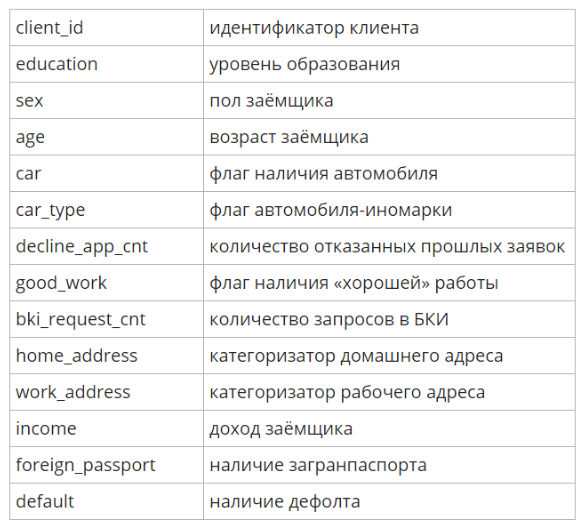

Из информационной таблицы видно, что незаполненный значениями один параметр <b>*education*</b>

Целевой переменной в данной задаче считается <b>*default*</b>

С целью выяснения принадлежности переменных к бинарному или псевдобинарному виду, определим переменные, количество уникальных значений которых ограничены (фиксируем не более 10 возможных вариантов).

# №1 Предобработка исходных данных

In [9]:
object_col =[]
for i in list(train_baza):
    if len(set(train_baza[i])) <10:
        object_col.append(i)
        print(i,'=>',set(train_baza[i]))        

education => {nan, 'SCH', 'PGR', 'UGR', 'ACD', 'GRD'}
sex => {'F', 'M'}
car => {'N', 'Y'}
car_type => {'N', 'Y'}
good_work => {0, 1}
home_address => {1, 2, 3}
work_address => {1, 2, 3}
foreign_passport => {'N', 'Y'}
default => {0, 1}


In [10]:
# Столбец education содержит количество уникальных значений
print(train_baza.education.value_counts())
print('Количество пустых ячеек = ',train_baza['education'].isnull().sum())

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64
Количество пустых ячеек =  307


In [11]:
# Разделим исходный датасет train_baza на два датасет train_baza_num и train_baza_bin. В первом датасете будут
# находится некатегориальные признаки, во втором бинарные и псевдобинарные
train_baza_num = pd.DataFrame(train_baza.drop(object_col, axis = 1))
object_col.append('client_id')
train_baza_bin = pd.DataFrame(train_baza[object_col])

In [12]:
# Заменим пропуски - nan  в столбце education на NN
train_baza_bin['education'] = train_baza_bin['education'].fillna('NN')

In [13]:
# Категориальные признаки столбцов списка object_col преобразуем с использованием класса LabelEncoder
encoder = LabelEncoder()
for f in object_col:
    if f !='client_id':
        train_baza_bin[f] = encoder.fit_transform(train_baza_bin[f])

# Вывод уникальных значений после преобразования категориальных признаков
for i in list(train_baza_bin):
    if len(set(train_baza_bin[i])) <10:
        train_baza_bin[i] = train_baza_bin[i]+1 # Добавим единицу с целью исключения появления 0
        print(i,'=>',set(train_baza_bin[i]))   

education => {1, 2, 3, 4, 5, 6}
sex => {1, 2}
car => {1, 2}
car_type => {1, 2}
good_work => {1, 2}
home_address => {1, 2, 3}
work_address => {1, 2, 3}
foreign_passport => {1, 2}
default => {1, 2}


In [14]:
# Определение количествонного соответсвия значений, которым была заменены пустые ячейки, 
# произведём по количествоенному совпадению
print(train_baza_bin.education.value_counts())

5    38860
2    23365
6     9816
4     1257
3      307
1      194
Name: education, dtype: int64


В процессе преобразование классом LabelEncoder, пустые значения столбца *education* были заменены числом 3. Остальные уровни образования согласно соотвествия:
<p>SCH -   38860 = 5 -   38860</p>
<p>GRD -   23365 = 2 -   23365</p>
<p>UGR -    9816 = 6 -    9816</p>
<p>PGR -    1257 = 4 -    1257</p>
<p>ACD -     194 = 1 -     194</p>
<p>Name: education, dtype: int64</p>
<p>Количество пустых ячеек =  307 => 3 - 307</p>

<p>Значения параметра *sex* женщина - F, мужчина - M, были заменены на 1 и 2 соответственно</p>
<p>Значения параметра *car* нет машины - N, и есть машина - Y, были заменены на 1 и 2 соответственно</p>
<p>Значения параметра *car_type* не иномарка - N, и иномарка - Y, были заменены на 1 и 2 соответственно</p>
<p>Значения параметра *foreign_passport* нет загранпаспорта - N, и есть загранпаспорт - Y, были заменены на 1 и 2 соответственно</p>


#### Замена пустых ячеек числом 3 временная. Окончательное заполнение ячеек будет производится в результате обучения датасета, где целевой переменной будет выступать столбец education
Проведём обработку датасета train_baza_num

In [15]:
train_baza_num.describe()

,client_id,age,decline_app_cnt,bki_request_cnt,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,2.000339,41099.775417
std,31841.921168,11.520378,0.804272,2.252073,46166.322400
min,1.000000,21.000000,0.000000,0.000000,1000.000000
25%,27440.500000,30.000000,0.000000,0.000000,20000.000000
50%,55274.000000,37.000000,0.000000,1.000000,30000.000000
75%,82758.500000,48.000000,0.000000,3.000000,48000.000000
max,110147.000000,72.000000,33.000000,53.000000,1000000.000000


Наблюдается существенная количественная разница в столбце *income*

In [16]:
# Применим процедуру понижения разряда. Видно, что значения столбца income можно понизить на три разряда
train_baza_num['income'] = train_baza_num['income']/1000
print('Минимальное значение столбца income = ',train_baza_num['income'].min())
print('Максимальное значение столбца income = ',train_baza_num['income'].max())

Минимальное значение столбца income =  1.0
Максимальное значение столбца income =  1000.0


Однако, после этой процедуры сохраняется числовой разрыв между минимальным и максимальным значениями в 1000 раз.
В качестве дополнительной процедуры "сглаживания" разрыва, применим процедуру логарифмирования. Процедуру применим ко всем столбцам датасета train_baza_num, за исключением столбца *client_id*

In [17]:
for column in train_baza_num.columns[1:]:
    try:
        train_baza_num[column] = np.log(train_baza_num[column]+1)
    except (ValueError, AttributeError):
        pass
train_baza_num.describe()

,client_id,age,decline_app_cnt,bki_request_cnt,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,3.655332,0.152451,0.878014,3.477366
std,31841.921168,0.285077,0.362971,0.657881,0.672842
min,1.000000,3.091042,0.000000,0.000000,0.693147
25%,27440.500000,3.433987,0.000000,0.000000,3.044522
50%,55274.000000,3.637586,0.000000,0.693147,3.433987
75%,82758.500000,3.891820,0.000000,1.386294,3.891820
max,110147.000000,4.290459,3.526361,3.988984,6.908755


Объеденим датасеты train_baza_num и train_baza_bin по парметру *client_id*

In [18]:
new_train_baza = train_baza_num.merge(train_baza_bin)

In [19]:
# Удалим из полученного датасета столбец client_id, как неинформативный
new_train_baza = new_train_baza.drop('client_id', axis=1)

In [20]:
# Проверяем датасет на наличие дубликатов строк
dub= new_train_baza[new_train_baza.duplicated()]
print('Количество дубликатов строк =',len(dub))

Количество дубликатов строк = 7022


In [21]:
# Удаляем дубликаты строк, оставляя строки первого вхождения (при окончательном обучении модели дубликаты удаляться не будут)
new_train_baza = new_train_baza.drop_duplicates()
new_train_baza.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66777 entries, 0 to 73797
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               66777 non-null  float64
 1   decline_app_cnt   66777 non-null  float64
 2   bki_request_cnt   66777 non-null  float64
 3   income            66777 non-null  float64
 4   education         66777 non-null  int32  
 5   sex               66777 non-null  int32  
 6   car               66777 non-null  int32  
 7   car_type          66777 non-null  int32  
 8   good_work         66777 non-null  int64  
 9   home_address      66777 non-null  int64  
 10  work_address      66777 non-null  int64  
 11  foreign_passport  66777 non-null  int32  
 12  default           66777 non-null  int64  
dtypes: float64(4), int32(5), int64(4)
memory usage: 5.9 MB


In [22]:
# Расчёт выбросов по столбцам
for y in list(new_train_baza):
    Q1_date = new_train_baza[y].quantile(.25)
    Q3_date = new_train_baza[y].quantile(.75)
    q1_date = Q1_date-1.5*(Q3_date-Q1_date)
    q3_date = Q3_date+1.5*(Q3_date-Q1_date)
    min_q = [x for x in new_train_baza[y] if x < q1_date]
    max_q = [x for x in new_train_baza[y] if x > q3_date]
    if len(min_q) == 0 and len(max_q):
        print('Столбец ', y, ' выбросов не имеет')
    else:
        print('Столбец ', y, ' имеет', len(min_q) + len(max_q), 'выбросов') 

Столбец  age  имеет 0 выбросов
Столбец  decline_app_cnt  выбросов не имеет
Столбец  bki_request_cnt  выбросов не имеет
Столбец  income  имеет 1086 выбросов
Столбец  education  имеет 0 выбросов
Столбец  sex  имеет 0 выбросов
Столбец  car  имеет 0 выбросов
Столбец  car_type  выбросов не имеет
Столбец  good_work  выбросов не имеет
Столбец  home_address  имеет 0 выбросов
Столбец  work_address  имеет 0 выбросов
Столбец  foreign_passport  выбросов не имеет
Столбец  default  выбросов не имеет


Выбросы присутствуют только в столбце *income*, что логично, так как за кредитами обращаются клиенты с разным уровнем дохода.
Строки в которых присутствуют выбросы из датасета удаляться не будут.

###### Проведём проверку датасета на наличие коллинеарности признаков.

Посчитаем взаимосвязь между признаками путём вычисления коэффициента корреляции Пирсона. Это мера интенсивности и направления линейной зависимости между двумя переменными. Значение +1 означает идеально линейную положительную зависимость, а -1 означает идеально линейную отрицательную зависимость. Будем считать, что взаимосвязь между параметрами сильная при уровне корреляции выше 0.7

In [23]:
corr = new_train_baza.corr()
for i in list(corr):
    for j in range(0,len(corr)):
        if corr[i][j] >0.7 and corr[i][j] !=1:
            zn = corr[i][j]
            print(i,zn)


home_address 0.7144747348004825
work_address 0.7144747348004825


Наблюдается сильная взаимосвязь между признаками *home_address* и *work_address*, что так же обяснимо, за кредитом чаще обращаются частные предпиниматели, юридический адрес их компаний совпадает с адерсом их проживания. Удалим из датасета признак *work_address*.

In [24]:
# Удаляем признак work_address из датасета
new_train_baza = new_train_baza.drop('work_address', axis=1)

# Признак столбца home_address преобразуем с использованием метода get_dummies
new_train_baza = pd.get_dummies(new_train_baza, columns=[ 'home_address',], dummy_na=False)
new_train_baza

,age,decline_app_cnt,bki_request_cnt,income,education,sex,car,car_type,good_work,foreign_passport,default,home_address_1,home_address_2,home_address_3
0,4.143135,0.000000,0.693147,2.944439,5,2,2,2,1,1,1,1,0,0
1,4.094345,0.000000,1.386294,2.995732,5,1,1,1,1,1,1,0,1,0
2,3.258097,1.098612,0.693147,3.433987,5,2,2,1,1,2,1,1,0,0
3,3.988984,0.000000,1.098612,2.397895,5,1,1,1,1,1,1,0,1,0
4,3.891820,0.000000,0.693147,3.433987,2,2,1,1,2,2,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73793,3.891820,0.000000,0.000000,3.583519,5,1,1,1,1,2,1,0,1,0
73794,3.828641,0.000000,1.386294,2.890372,2,1,1,1,1,1,1,1,0,0
73795,3.737670,0.000000,0.693147,4.262680,5,2,2,2,1,1,1,0,1,0
73796,3.465736,0.000000,1.609438,3.828641,5,2,1,1,1,1,1,0,1,0


In [25]:
# Выведем коэффициенты корреляции признаков с признаком default
correlations_data = corr['default'].sort_values()
correlations_data

foreign_passport   -0.077664
car_type           -0.065905
income             -0.064430
car                -0.055360
good_work          -0.053457
age                -0.026555
sex                 0.014102
bki_request_cnt     0.071318
education           0.081491
work_address        0.087134
home_address        0.089155
decline_app_cnt     0.116789
default             1.000000
Name: default, dtype: float64

Ни один из признаков с целевым признаком default не связан.

### Проведём анализ признаков sex и education

#### Пол(sex)
Проверим гипотезу, что половые различия кредитозаёмщика не влияют на модель расчёта. Если статистические данные будут схожи, т.е. не имеют существенных различий, то признак *sex* из датасета можно удалить

In [26]:
true_0 = new_train_baza[new_train_baza.default == 1]
print('Рекомендовано к выдаче кредита ',len(true_0),'клиентам')
male_true = len(true_0.loc[true_0.sex == 2])
female_true = len(true_0.loc[true_0.sex == 1])
print('Из них мужчин',male_true)
print('Из них женщин',female_true)
false_1 = new_train_baza[new_train_baza.default == 2]
print('Не рекомендовано к выдаче кредита ',len(false_1),'клиентов')
male_false = len(false_1.loc[false_1.sex == 2])
female_false = len(false_1.loc[false_1.sex == 1])
print('Из них мужчин',male_false)
print('Из них женщин',female_false)
print('Процент рекомендованных к выдаче кредитов мужчинам =', round(100*male_true/len(true_0),2))
print('Процент рекомендованных к выдаче кредитов женщинам =', round(100*female_true/len(true_0),2))
print('Процент не рекомендованных к выдаче кредитов мужчинам =', round(100*male_false/len(false_1),2))
print('Процент не рекомендованных к выдаче кредитов женщинам =', round(100*female_false/len(false_1),2))
print('==============')
print('Количество женщин обратившихся за кредитом =', female_true+female_false, ', в процентах ',round(100*(female_true+female_false)/(len(true_0)+len(false_1)),2))
print('Количество мужчин обратившихся за кредитом =', male_true+male_false, ', в процентах ',round(100*(male_true+male_false)/(len(true_0)+len(false_1)),2))

Рекомендовано к выдаче кредита  57681 клиентам
Из них мужчин 25588
Из них женщин 32093
Не рекомендовано к выдаче кредита  9096 клиентов
Из них мужчин 4221
Из них женщин 4875
Процент рекомендованных к выдаче кредитов мужчинам = 44.36
Процент рекомендованных к выдаче кредитов женщинам = 55.64
Процент не рекомендованных к выдаче кредитов мужчинам = 46.41
Процент не рекомендованных к выдаче кредитов женщинам = 53.59
Количество женщин обратившихся за кредитом = 36968 , в процентах  55.36
Количество мужчин обратившихся за кредитом = 29809 , в процентах  44.64


Количество женщин обращаются за предоставлением кредита чаще, чем мужчин (чуть больше 10%).
Отказывают женщинам также чаще, чем и мужчинам, так же чуть больше 10%, что видимо не связано с половыми различиями, а связано напрямую с частотой обращений за кредитом как фактом. Это подтверждается тем, что утверждают кредит женщинам также чаще чем мужчинам на 10%. В связи с этим, признак *sex* так же можно исключить из датасета как незначимый.
<p><b>Примечание:</b></p>

*Вполне возможно женская активность в получении кредита связана с тем, что в основном женщины имеют стабильную работу, как следствие - стабильный доход.*

Проверим как половые различия кредитозаёмщика влияют на модель расчёта при заполнении признака *education*
Таблица замен
<p>SCH  = 5 </p>
<p>GRD  = 2 </p>
<p>UGR  = 6 </p>
<p>PGR  = 4 </p>
<p>ACD  = 1 </p>


In [27]:
# Расчитаем коэффициент корреляции признаков от признака education
correlations_data = corr['education'].sort_values()
correlations_data

income             -0.258217
car_type           -0.145139
good_work          -0.141735
foreign_passport   -0.141624
car                -0.099346
bki_request_cnt    -0.032569
sex                -0.015596
home_address        0.009433
work_address        0.012587
age                 0.015174
decline_app_cnt     0.062973
default             0.081491
education           1.000000
Name: education, dtype: float64

Сильной взаимосвязи признаков с временным целевым признаком education нет.

In [28]:
sch_male = len([x for x in list(new_train_baza[new_train_baza.education == 5]['sex']) if x ==2]) # Количество мужчин с уровнем образования SCH
sch_female = len([x for x in list(new_train_baza[new_train_baza.education == 5]['sex']) if x ==1])  # Количество женщин с уровнем образования SCH
print('Количество мужчин и женщин имеющих образование SCH - школа       (',sch_male,' -- ',sch_female, ') -> класс = 5')
grd_male = len([x for x in list(new_train_baza[new_train_baza.education == 2]['sex']) if x ==2]) # Количество мужчин с уровнем образования GRD
grd_female = len([x for x in list(new_train_baza[new_train_baza.education == 2]['sex']) if x ==1])  # Количество женщин с уровнем образования GRD
print('Количество мужчин и женщин имеющих образование GRD - бакалавриат (',grd_male,' -- ',grd_female, ') -> класс = 2')
urg_male = len([x for x in list(new_train_baza[new_train_baza.education == 6]['sex']) if x ==2])# Количество мужчин с уровнем образования UGR
urg_female = len([x for x in list(new_train_baza[new_train_baza.education == 6]['sex']) if x ==1]) # Количество женщин с уровнем образования UGR
print('Количество мужчин и женщин имеющих образование UGR - магистр     (',urg_male,' -- ',urg_female, ') -> класс = 6')
pgr_male = len([x for x in list(new_train_baza[new_train_baza.education == 4]['sex']) if x ==2]) # Количество мужчин с уровнем образования PGR 
pgr_female = len([x for x in list(new_train_baza[new_train_baza.education == 4]['sex']) if x ==1]) # Количество женщин с уровнем образования PGR 
print('Количество мужчин и женщин имеющих образование PGR - аспирант    (',pgr_male,' -- ',pgr_female, ') -> класс = 4')
acd_male = len([x for x in list(new_train_baza[new_train_baza.education == 1]['sex']) if x ==2])# Количество мужчин с уровнем образования ACD 
acd_female = len([x for x in list(new_train_baza[new_train_baza.education == 1]['sex']) if x ==1]) # Количество женщин с уровнем образования ACD 
print('Количество мужчин и женщин имеющих образование ACD - профессор   (',acd_male,' -- ',acd_female, ') -> класс = 1')

Количество мужчин и женщин имеющих образование SCH - школа       ( 14572  --  19221 ) -> класс = 5
Количество мужчин и женщин имеющих образование GRD - бакалавриат ( 10045  --  11876 ) -> класс = 2
Количество мужчин и женщин имеющих образование UGR - магистр     ( 4315  --  4996 ) -> класс = 6
Количество мужчин и женщин имеющих образование PGR - аспирант    ( 624  --  627 ) -> класс = 4
Количество мужчин и женщин имеющих образование ACD - профессор   ( 115  --  79 ) -> класс = 1


Наблюдается явное отсутствие нормального распределение уровня образования клиентов, и несильное различие по уровню образования между мужчинами и женщинами одного уровня. Что ещё раз подтверждает решение удалить признак *sex* из расчётов в модели. Признак *sex* также не понадобится при расчёте уровня образования для пустых значений параметра *education*.

In [29]:
# Удаляем признак sex из датасета
new_train_baza = new_train_baza.drop('sex', axis=1)

#### Уровень образования (education)

Наблюдается существенная разбалансировка классов: 1, 2, 4, 5, 6.
Для решения задачи, заполнения пустых значений признака *education* проведём сравнительный анализ моделей классификации:
- классификатор дерева решений Decision Tree Classifier;
- метод k-ближайших соседей
- нейронной сети конструктором MLPClassifier()

In [30]:
# Создаём рабочую копию df датасета new_train_baza
df = new_train_baza.copy()
df = pd.DataFrame(df.reset_index(drop=True))

In [31]:
# Разделяем копию на два датасет. Тренировочный и тестовый. В тернировачный войдут все строки, 
# за исключением строк, значения ячейк которых параметра education  равно 3
df_train = df[df['education'] != 3]
y_trin = df_train['education']
df_train_N = df_train.drop('education', axis=1)
df_train_N = pd.DataFrame(df_train_N.reset_index(drop=True))
df_test = df[df['education'] == 3]
df_test = df_test.drop('education', axis=1)
df_test = pd.DataFrame(df_test.reset_index(drop=True))

In [32]:
# Проведём разбиение df_train на обучающий X_train и Y_train, тестовый X_test и Y_test. Разобьём с перемешиванием, доля тестовой
# выборки определим как 33%
X_train, X_test, Y_train, Y_test = train_test_split(df_train_N, y_trin,  test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)

Для расчёта значений уровня образования тестируем три модели классификации из библиотеки Scikit-Learn:
1. Метод k-ближайших соседей sklearn.neighbors (гиперпараметры оптимизируем ручным способом)
2. Метода классификатор дерева решений (Decision Tree Classifier)(гиперпараметры оставим по умолчанию)
3. С помощью нейронной сети конструктора MLPClassifier()

<p>Для оценки точности классификаторов импортируем метрики:</p>
- classification_report
- confusion_matrix
- accuracy_score
#### Предварительный расчёт с целью определения лучшей модели

In [33]:
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [34]:
# Нормализуем данные, путём удаления среднего и масштабирования до единичной дисперсии
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Проведём обучение моделей и осуществим оценку их точности

In [35]:
KNN_model = KNeighborsClassifier(n_neighbors=4) # Пераметр n_neighbors=4 подобран вручную путём перебора в диапазоне от 1 до 10
KNN_model = KNN_model.fit(X_train, Y_train)

myModel_tree = DecisionTreeClassifier(random_state=RANDOM_SEED)
myModel_tree = myModel_tree.fit(X_train, Y_train)

myModel_MLP = MLPClassifier(random_state=RANDOM_SEED, max_iter=200)
myModel_MLP = myModel_MLP.fit(X_train, Y_train)

KNN_prediction = KNN_model.predict(X_test)
Tree_prediction = myModel_tree.predict(X_test)
MLP_prediction = myModel_MLP.predict(X_test)

# Оценка точности — простейший вариант оценки работы классификатора
print('Оценка точности k-ближайших соседей')
print(accuracy_score(KNN_prediction, Y_test),'\n')
print('Оценка точности классификатора дерева решений')
print(accuracy_score(Tree_prediction, Y_test),'\n')
print('Оценка точности MLP')
print(accuracy_score(MLP_prediction, Y_test),'\n')


# Но матрица неточности и отчёт о классификации дадут больше информации о производительности
print('Матрица неточности метода k-ближайших соседей')
print(classification_report(KNN_prediction, Y_test),'\n')
print('Матрица неточности метода классификатора дерева решений')
print(confusion_matrix(Tree_prediction, Y_test),'\n') 
print('Матрица неточности метода нейронной сети')
print(confusion_matrix(MLP_prediction, Y_test),'\n') 

Оценка точности k-ближайших соседей
0.49295421493405545 

Оценка точности классификатора дерева решений
0.4255553883957675 

Оценка точности MLP
0.5761496414422547 

Матрица неточности метода k-ближайших соседей
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        51
           2       0.51      0.41      0.46      8016
           4       0.00      0.02      0.00        51
           5       0.62      0.59      0.61     10780
           6       0.06      0.17      0.09      1043

    accuracy                           0.49     19941
   macro avg       0.24      0.24      0.23     19941
weighted avg       0.54      0.49      0.51     19941
 

Матрица неточности метода классификатора дерева решений
[[   1   33    3   27   14]
 [  24 2646  195 3213 1006]
 [   3  233   22  164   50]
 [  21 2806  144 5453 1331]
 [   7  839   39 1303  364]] 

Матрица неточности метода нейронной сети
[[   0    0    0    0    0]
 [  44 3385  281 2078  918]
 

Получим расчётные значения для пустых значений параметра education по трём моделям

In [36]:
y_education_tree = myModel_tree.predict(df_test)
print('Сводные данные метода классификатора дерева решений')
print(pd.Series(y_education_tree).value_counts(),'\n')

y_education_knn = KNN_model.predict(df_test)
print('Сводные данные метода k-ближайших соседей')
print(pd.Series(y_education_knn).value_counts(),'\n')

y_education_MLP = myModel_MLP.predict(df_test)
print('Сводные данные метода MLP')
print(pd.Series(y_education_MLP).value_counts(),'\n')

Сводные данные метода классификатора дерева решений
1    307
dtype: int64 

Сводные данные метода k-ближайших соседей
2    286
5     14
1      7
dtype: int64 

Сводные данные метода MLP
2    307
dtype: int64 



Для заполнения пустых значений параметра education выберем модель нейронной сети, так как оценка точности этого метода выше чем у других моделей.
#### Окончательный расчёт 
Для осуществления окончательного расчёта проведём обучение модели на 100% выборке исходного датасета df_train_N

In [37]:
# Фиксация обучающих данных
X_train = df_train_N.copy()
Y_train = y_trin.copy()

# Нормализуем данные, путём удаления среднего и масштабирования до единичной дисперсии
X_train = scaler.fit_transform(X_train)

# Фиксация модели и обучение
myModel_MLP = MLPClassifier(random_state=RANDOM_SEED, max_iter=200)
myModel_MLP = myModel_MLP.fit(X_train, Y_train)

# Получение расчётных параметров на основании обученной модели
y_education_finish = myModel_MLP.predict(df_test)

print('Сводные данные метода MLPClassifier')
print(pd.Series(y_education_finish).value_counts(),'\n')

Сводные данные метода MLPClassifier
2    307
dtype: int64 



Моделью, из 307 пустых вариантов уровней образования предсказано:

<p>2 = GRD - 307 клиентов</p>

In [38]:
# Заполнение строк расчётными значениями
for i in range(0,len(y_education_finish)):
    df_test.at[i,'education'] = y_education_finish[i]

In [39]:
# Объеденим датасеты в единый
df = pd.concat([df_test, df_train])
df['education'] = df['education'].astype('str')
df = pd.DataFrame(df.reset_index(drop=True))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66777 entries, 0 to 66776
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               66777 non-null  float64
 1   decline_app_cnt   66777 non-null  float64
 2   bki_request_cnt   66777 non-null  float64
 3   income            66777 non-null  float64
 4   car               66777 non-null  int32  
 5   car_type          66777 non-null  int32  
 6   good_work         66777 non-null  int64  
 7   foreign_passport  66777 non-null  int32  
 8   default           66777 non-null  int64  
 9   home_address_1    66777 non-null  uint8  
 10  home_address_2    66777 non-null  uint8  
 11  home_address_3    66777 non-null  uint8  
 12  education         66777 non-null  object 
dtypes: float64(4), int32(3), int64(2), object(1), uint8(3)
memory usage: 4.5+ MB


В результате получаем датасет с заполненным значениями по всем признакам

In [40]:
# Повторим процедуру просмотра уникальных значений по признакам имеющим не более 10 варантов уникальных значений
object_col =[]
for i in list(df):
    if len(set(df[i])) <10:
        object_col.append(i)
        print(i,'=>',set(df[i]))

car => {1, 2}
car_type => {1, 2}
good_work => {1, 2}
foreign_passport => {1, 2}
default => {1, 2}
home_address_1 => {0, 1}
home_address_2 => {0, 1}
home_address_3 => {0, 1}
education => {'2.0', '5.0', '1.0', '6.0', '4.0'}


Для проведения процедуры get_dummies, для читаемости наименования столбцов уровня образования проведём обратную замену в столбце education согласно таблицы:
<p>SCH  = 5 </p>
<p>GRD  = 2 </p>
<p>UGR  = 6 </p>
<p>PGR  = 4 </p>
<p>ACD  = 1 </p>

In [41]:
for i in range(0,len(df)):
    if df['education'][i] == '1.0':
        df.at[i,'education'] = 'ACD'
    if df['education'][i] == '2.0':
        df.at[i,'education'] = 'GRD'
    if df['education'][i] == '4.0':
        df.at[i,'education'] = 'PGR'
    if df['education'][i] == '5.0':
        df.at[i,'education'] = 'SCH'
    if df['education'][i] == '6.0':
        df.at[i,'education'] = 'UGR'

#### Визуализируем соотношение уровня образования с дефорлтом

Text(0.5, 1.0, 'Дефолты, в зависимости от уровня образования')

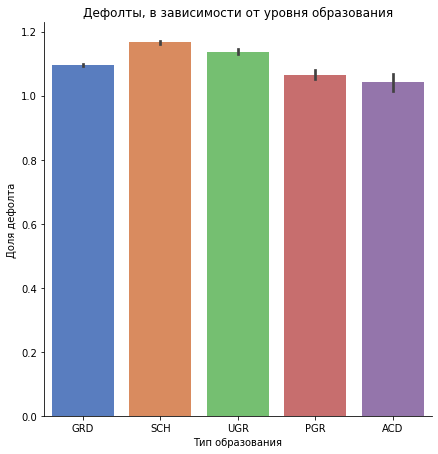

In [42]:
sns.catplot(x='education', y='default',  data=df, kind="bar", palette="muted", height = 6)
plt.ylabel(u'Доля дефолта')
plt.xlabel(u'Тип образования')
plt.title(u'Дефолты, в зависимости от уровня образования')

Все уровни образования не имеют существенных различий, поэтому ни одну из групп исключить нельзя из расчёта.
##### В абсолютных значениях

In [43]:
tableEducation = pd.DataFrame({u'Без дефолта': df[df['default'] == 1].education.value_counts(), u'С дефолтом': df[df['default'] == 2].education.value_counts()})
tableEducation

,Без дефолта,С дефолтом
SCH,28183,5610
GRD,20108,2120
UGR,8034,1277
PGR,1170,81
ACD,186,8


In [44]:
# Признак столбца education преобразуем с использованием метода get_dummies
df_new = pd.get_dummies(df, columns=[ 'education',], dummy_na=False)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66777 entries, 0 to 66776
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               66777 non-null  float64
 1   decline_app_cnt   66777 non-null  float64
 2   bki_request_cnt   66777 non-null  float64
 3   income            66777 non-null  float64
 4   car               66777 non-null  int32  
 5   car_type          66777 non-null  int32  
 6   good_work         66777 non-null  int64  
 7   foreign_passport  66777 non-null  int32  
 8   default           66777 non-null  int64  
 9   home_address_1    66777 non-null  uint8  
 10  home_address_2    66777 non-null  uint8  
 11  home_address_3    66777 non-null  uint8  
 12  education_ACD     66777 non-null  uint8  
 13  education_GRD     66777 non-null  uint8  
 14  education_PGR     66777 non-null  uint8  
 15  education_SCH     66777 non-null  uint8  
 16  education_UGR     66777 non-null  uint8 

### Визуализируем распределение образовательного уровня клиентов

{'SCH': 33793, 'GRD': 22228, 'UGR': 9311, 'PGR': 1251, 'ACD': 194}


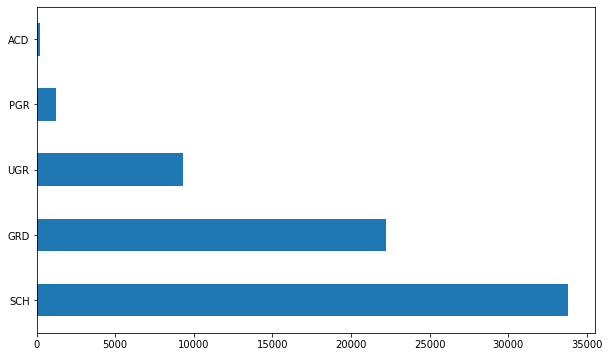

In [45]:
plt.rcParams['figure.figsize'] = (10,6)
# График - количество ресторанов в городах
df['education'].value_counts().plot(kind='barh')

# Получаем полный список уровней образования представленных в признаке education
education = dict(df['education'].value_counts())
education_pop = education.copy()
print(education)

<b>Вывод:</b> гипотеза о независимости образования и наличия/отсутствия просрочек в оплате кредита отвергается. Поэтому признак education является важным при рассмотрении заявки на кредит.

#### Целевой признак дефолта default

Количество дефолтных клиентов банка = 9096
Количество не дефолтных клиентов банка = 57681
Соотношение классов = 0.16


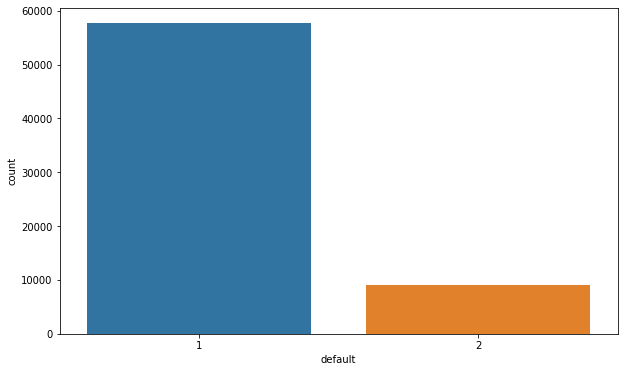

In [46]:
# Количество дефолтных клиентов банка меньше,чем недефолтных
sns.countplot(x='default', data=df_new)
k_def = len(df_new[df_new['default'] ==2])
k_nodef = len(df_new[df_new['default'] ==1])
print('Количество дефолтных клиентов банка =',k_def)
print('Количество не дефолтных клиентов банка =',k_nodef)
# Соотношение классов дефолтных к недефолтным
print('Соотношение классов =',round(k_def/k_nodef,2))

В связи с тем, что соотношение классов 0.16, чуть выше рекомендуемого соотношения 0.1, то целесообразно рассмотреть насколько разбалансированны данные по целевому признаку <b>default</b>

In [47]:
print('Показатели дефолтных клиентов')
df_ag1 = df_new.loc[df_new['default']==2]
print('Признак age ',df_ag1['age'].mean())
print('Признак decline_app_cnt ',df_ag1['decline_app_cnt'].mean())
print('Признак bki_request_cnt ',df_ag1['bki_request_cnt'].mean())
print('Признак income ',df_ag1['income'].mean(),'\n')
print('Показатели недефолтных клиентов')
df_ag0 = df_new.loc[df_new['default']==1]
print('Признак age ',df_ag0['age'].mean())
print('Признак decline_app_cnt ',df_ag0['decline_app_cnt'].mean())
print('Признак bki_request_cnt ',df_ag0['bki_request_cnt'].mean())
print('Признак income ',df_ag0['income'].mean(),'\n')
print('Совпадение в процентах')
print('Признак age ',round(df_ag1['age'].mean()*100/df_ag0['age'].mean(),2))
print('Признак decline_app_cnt ',round(df_ag0['decline_app_cnt'].mean()*100/df_ag1['decline_app_cnt'].mean(),2))
print('Признак bki_request_cnt ',round(df_ag0['bki_request_cnt'].mean()*100/df_ag1['bki_request_cnt'].mean(),2))
print('Признак income ',round(df_ag1['income'].mean()*100/df_ag0['income'].mean(),2))

Показатели дефолтных клиентов
Признак age  3.6381409207547923
Признак decline_app_cnt  0.2768495369081859
Признак bki_request_cnt  1.0230743250036847
Признак income  3.387712665908843 

Показатели недефолтных клиентов
Признак age  3.6602984602417705
Признак decline_app_cnt  0.1486009392416024
Признак bki_request_cnt  0.8850354683908908
Признак income  3.5166319808102218 

Совпадение в процентах
Признак age  99.39
Признак decline_app_cnt  53.68
Признак bki_request_cnt  86.51
Признак income  96.33


### Средние значения признаков возраст (age) и доход (income) разбалансированны несущественно!!!
Существенное отличие в признаках decline_app_cnt и bki_request_cnt, у дефолтных выше, что естественно, они внесут свой вклад в оценку клиента на дефолтность

##### Значимость  переменных 

Для оценки значимости числовых переменных используем функцию f_classif из библиотеки sklearn.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок.

В качестве меры значимости используется значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак модели.

<AxesSubplot:>

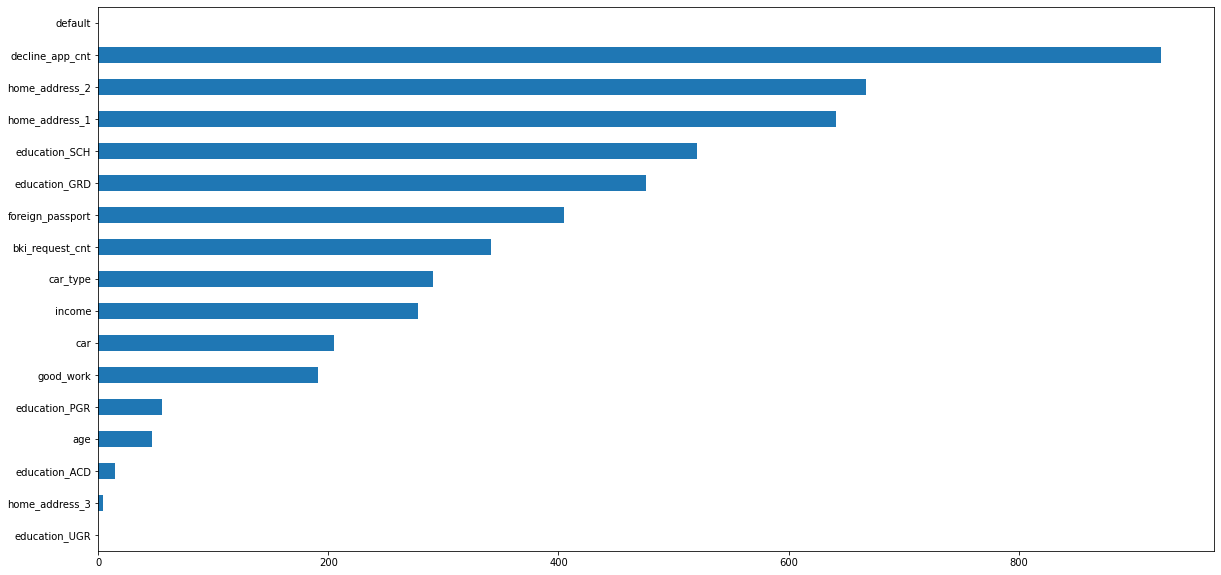

In [48]:
import warnings # игнорирование предупреждений
warnings.filterwarnings('ignore')

num_cols = list(df_new)
plt.figure(figsize=(20,10))
imp_num = Series(f_classif(df_new[num_cols], df_new['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Для обнаружения возможных взаимосвязей признаков выведем тепловую карту матрицы корреляции

<AxesSubplot:>

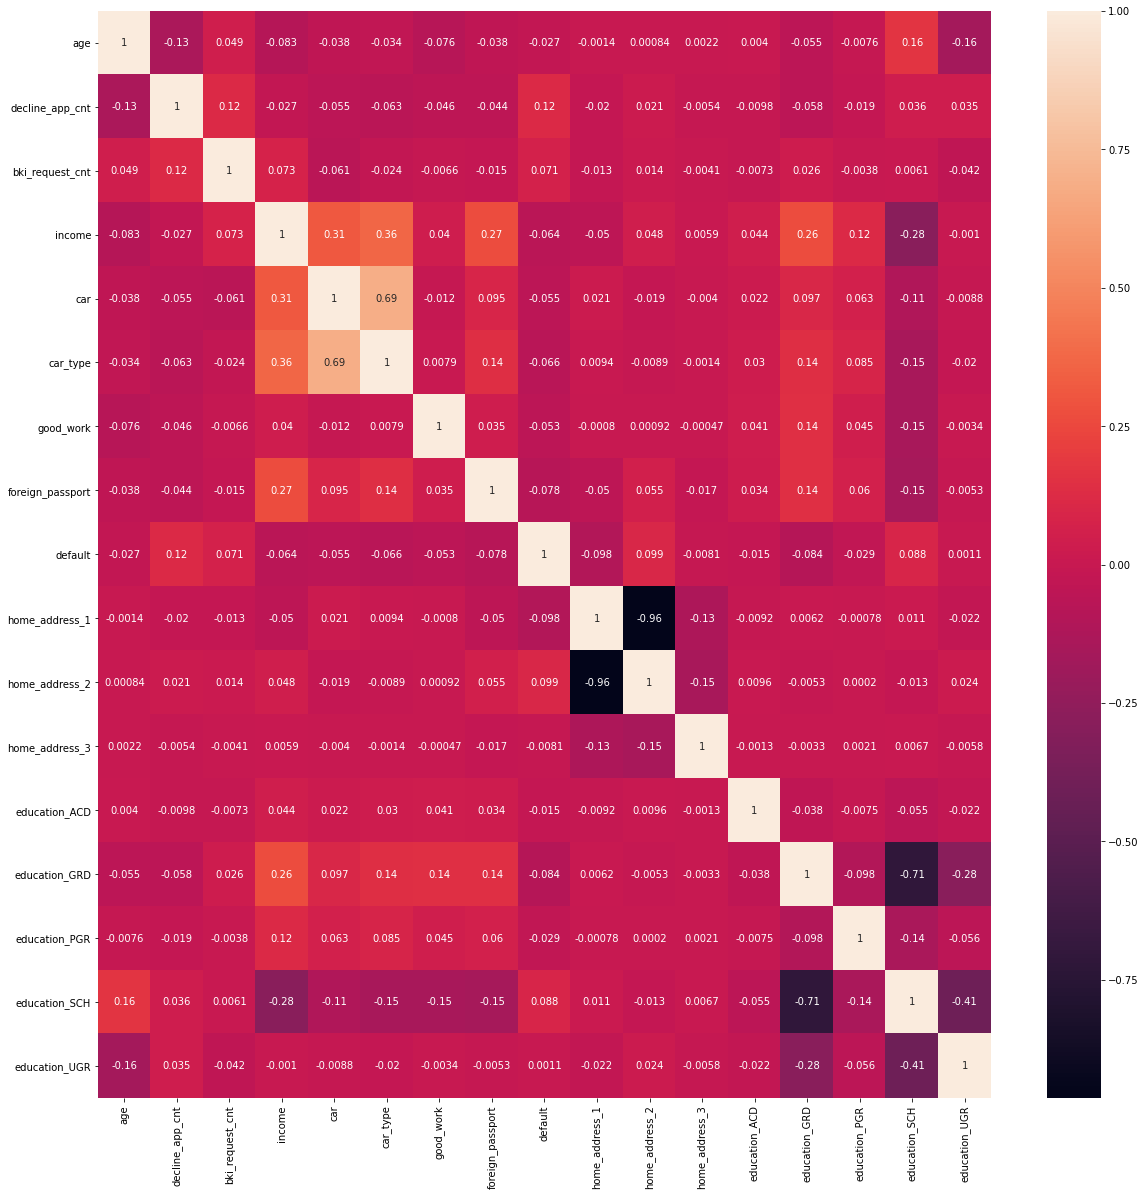

In [49]:
plt.figure(figsize=(20,20))
myBasicCorr = df_new.corr(method='pearson')
sns.heatmap(myBasicCorr, annot = True)

Наблюдается сильная взаимосвязь двух признаков education_SCH (школа) c education_GRD (бакалавриат), коэффициент корреляции которой равен 0.71.

С учётом графика значимости признаков удалим менее значимый признак education_GRD

Так же наблюдается сильная взаимосвязь двух признаков home_address_1  c home_address_2, коэффициент корреляции которой равен 0.96.

С учётом графика значимости признаков удалим менее значимый признак home_address_1

In [50]:
# Удаляем признак education_GRD из датасета
df_new = df_new.drop('education_GRD', axis=1)
# Удаляем признак home_address_1 из датасета
df_new = df_new.drop('home_address_1', axis=1)

##### Для обучения выберем две модели LogisticRegression() и MLPClassifier().
По первой модели осуществим подбор гипперпараметров таким образом, чтобы оценка точности модели была близка к оценке точности, полученной по второй модели - MLPClassifier().

### Модель MLPClassifier()

In [51]:
# Стандартизация числовых переменных
num_cols = list(df_new)
num_cols.remove('default')
Y = df_new['default'].values

# Удаляем признак default из датасета X
df = df_new.drop('default', axis=1)

X = StandardScaler().fit_transform(df[num_cols].values)

# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [52]:
myModel_MLP = MLPClassifier(random_state=RANDOM_SEED, max_iter=200).fit(X_train, y_train)
y_pred=myModel_MLP.predict(X_test)
print('Оценка точности MLP модели')
print(accuracy_score(y_pred, y_test),'\n')

Оценка точности MLP модели
0.8607866626734552 



# № 2 Обучение модели LogisticRegression() 

Обработаем исходный датасет train_baza в соответствии с результатами полученными на стадии предобработки исходных данных:
1. Заполним пропуски признака education значением GRD
2. Удалим признак sex - пол
3. Удалим признак work_address - адрес оффиса
4. Распределим категориальные признаки:
-  education
-  car
-  car_type
-  good_work 
-  home_address 
-  work_address 
-  foreign_passport
5. Удалим признаки:
-  education_GRD
6. Нормализуем данные
- Понижаем разрядность значений столбца income на 3 разряда
- Нормализуем методом "прокола" (метод разработан автором проекта для понижения степени разряженности матрицы данных)
7. Выделим целевой признак default
8. Фиксируем конечные объём данных перед разбиением на тренировочную и тестовую части путём удаления столбцов default и client_id
9. Разобъём данные с помощью метода train_test_split на тренировочную и тестовую в соотношении 0.3 c перемешиванием
10. Нормализуем полученные тренировочные и тестовые данные методом fit_transform класса StandardScaler()
11. Проведём процедуру оптимизации гиперпарматров модели LogisticRegression()
12. Обучим модель и расчитаем прогнозируемый целевой признак default

In [53]:
# Импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

rezalt = [] # В список будут заносится результаты работы функции:
#     1. Оптимальный указатель нормы штрафа - индекс 0
#     2. Оптимальный инверсия силы регуляризации - индекс 1
#     3. Средняя точность для заданных тестовых данных и меток тестовой выборки - - индекс 2
#     4. Классификационная оценка точности всего датасета - индекс 3
#     5. Датасет sample_submission с столбцами: - индекс 4
#         - client_id - индификационный номер клиента;
#         - default - целевой признак дефолтности;
#         - predicted - предсказанная дефолтность.
#     6. Обученная модель LogisticRegression - индекс 5


# Фиксируем RANDOM_SEED и TEST_SIZE, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 45
TEST_SIZE = 0.3

# Загружаем представленные данные
train_baza = pd.read_csv('сredit_train.csv')

# Формируем sample_submission
sample_submission = train_baza[['client_id','default']]

# Заменим пропуски - nan  в столбце education на GRD
train_baza['education'] = train_baza['education'].fillna('GRD')

# Удаляем признак sex и work_address из датасета
train_baza = train_baza.drop(['sex','work_address'], axis=1)

# Признаки списка col_bin - наименований столбцов преобразуем с использованием метода get_dummies
col_bin = ['education','car','car_type','good_work','home_address','foreign_passport']
for col in col_bin:
    train_baza = pd.get_dummies(train_baza, columns=[col], dummy_na=False)

# Удаляем признак education_GRD из датасета
train_baza = train_baza.drop(['education_GRD'], axis=1)

# Понижаем разрядность значений столбца income на 3 разряда
train_baza['income'] = train_baza['income']/1000

# С целью уменьшения степени разряженности данных нормализуем  методом "прокола" (метод разработан автором этого проекта)
col_num = list(train_baza)
col_num.remove('client_id')
col_num.remove('default')
for col in col_num:
    n = train_baza[col].sum()
    for x in range(0,len(train_baza)):
        train_baza.at[x,col] = n - train_baza[col][x]# Прокол, поднятие значения ячейки на уровень суммы столбцы
        # с последующим вычитанием значения находящегося в этой ячейке
    try:
        train_baza[col] = np.log(train_baza[col]+1) # Логарифмирование полученного столбца
    except (ValueError, AttributeError):
        pass

# Выделим целевой признак default
Y = list(sample_submission['default'])

# Фиксируем конечные объём данных перед разбиением на тренировочную и тестовую части путём удаления
# столбцов default и client_id
X = train_baza.drop(['client_id','default'], axis=1)

# Проведём разбиение X и Y на обучающий X_train и Y_train, тестовый X_test и Y_test. Разобьём с перемешиванием, доля тестовой
# выборки определим как 33%

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)

# Нормализуем полученные тренировочные и тестовые данные методом fit_transform класса StandardScaler()
col_num = list(X_train)
X_train = StandardScaler().fit_transform(X_train[col_num].values)
X_test = StandardScaler().fit_transform(X_test[col_num].values)

# Проведём процедуру оптимизации гиперпарматров модели LogisticRegression()
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, Y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
hyper_CV = GridSearchCV(model, hyperparameters, cv=5, verbose=0)   

best_model = hyper_CV.fit(X_train, Y_train)

penalty = best_model.best_estimator_.get_params()['penalty']
rezalt.append(best_model.best_estimator_.get_params()['penalty'])

С = best_model.best_estimator_.get_params()['C']
rezalt.append(best_model.best_estimator_.get_params()['C'])

# Обучаем модель используя оптимизированные данные на тернинговой выборке
classifier = LogisticRegression(C = С, penalty = penalty,solver='lbfgs',random_state = RANDOM_SEED)
classifier.fit(X_train, Y_train)

# Получаем оценку обученной модели на тестовой выборке
rezalt.append(classifier.score(X_test, Y_test))

# Получаем прогноз дефолтности клиентов по всему датасету
predicted_Y = classifier.predict(X)

# Получаем оценку обученной модели по всему датасету
rezalt.append(accuracy_score(predicted_Y, Y))

# Формируем выходной датасет sample_submission
sample_submission['predicted'] = 0
for x in range(0,len(sample_submission)):
    sample_submission.at[x,'predicted'] = predicted_Y[x]
rezalt.append(sample_submission)        
rezalt.append(classifier)
    
rezalt

['l2',
 1.0,
 0.8686540198735321,
 0.8730064093009391,
        client_id  default  predicted
 0          25905        0          0
 1          63161        0          0
 2          25887        0          0
 3          16222        0          0
 4         101655        0          0
 ...          ...      ...        ...
 73794      54887        0          0
 73795      76821        0          0
 73796     103695        0          0
 73797        861        1          0
 73798      15796        0          0
 
 [73799 rows x 3 columns],
 LogisticRegression(random_state=45)]

In [54]:
predicted_y = rezalt[5].predict(X_test)

In [55]:
for x in range(len(predicted_y)):
    if (predicted_y[x] == 1):
        print(x,'|  Дефолтный клиент -> ',sample_submission['client_id'][x],sample_submission['default'][x])   

426 |  Дефолтный клиент ->  5461 0
1485 |  Дефолтный клиент ->  89027 0
1560 |  Дефолтный клиент ->  59309 0
1652 |  Дефолтный клиент ->  30966 0
1724 |  Дефолтный клиент ->  93042 1
1743 |  Дефолтный клиент ->  105128 0
1783 |  Дефолтный клиент ->  94726 0
1863 |  Дефолтный клиент ->  25479 0
2662 |  Дефолтный клиент ->  106682 0
2975 |  Дефолтный клиент ->  45434 1
3435 |  Дефолтный клиент ->  103248 0
3478 |  Дефолтный клиент ->  17713 0
3579 |  Дефолтный клиент ->  85369 0
3906 |  Дефолтный клиент ->  97478 0
4233 |  Дефолтный клиент ->  74721 1
4276 |  Дефолтный клиент ->  68612 0
4354 |  Дефолтный клиент ->  44633 0
5068 |  Дефолтный клиент ->  102094 1
5570 |  Дефолтный клиент ->  90056 0
5573 |  Дефолтный клиент ->  18767 0
5874 |  Дефолтный клиент ->  61835 0
6571 |  Дефолтный клиент ->  96869 0
7801 |  Дефолтный клиент ->  71798 0
8619 |  Дефолтный клиент ->  11516 0
9045 |  Дефолтный клиент ->  27961 0
9454 |  Дефолтный клиент ->  44129 0
9589 |  Дефолтный клиент ->  91423 0

#### Визуализируем логистическую регрессию

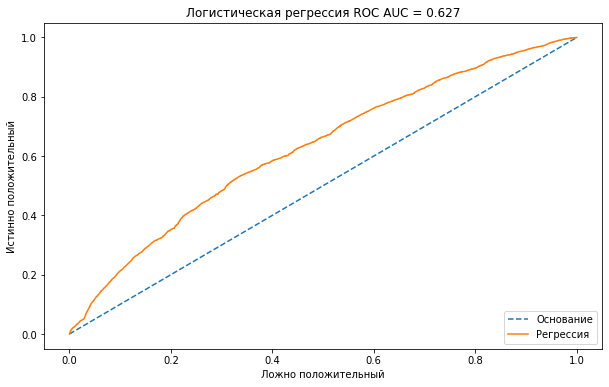

In [56]:
probs = rezalt[5].predict_proba(X)
probs = probs[:,1]

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(Y, probs)
roc_auc = roc_auc_score(Y, probs)

plt.figure()
plt.plot([0, 1], label='Основание', linestyle='--')
plt.plot(fpr, tpr, label = 'Регрессия')
plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc)
plt.ylabel('Истинно положительный')
plt.xlabel('Ложно положительный')
plt.legend(loc = 'lower right')
plt.show()

#### Выводы:
           1. Проведён предварительный анализ представленного датасета;
           2. Проведены процедуры предварительной обработки датасета;
           3. Применены несколько методов для принятия решений для оптимальной обработки датасета;
           4. Составлен пошаговый код для применения логистической регрессии и оптимизации её гиперпараметров;
           5. С учётом выше указанных пунктов создана функция credit_scoring_VP позволяющая обрабатывать и получать
           параметры характерезующие созданную модель к конкретному!!! датасету.
           6. Функция выводит результат в виде списка, элементами которого являются
              1. Оптимальный указатель нормы штрафа - индекс 0
              2. Оптимальный инверсия силы регуляризации - индекс 1
              3. Средняя точность для заданных тестовых данных и меток тестовой выборки - - индекс 2
              4. Классификационная оценка точности всего датасета - индекс 3
              5. Датасет sample_submission с столбцами: - индекс 4
                 - client_id - индификационный номер клиента;
                 - default - целевой признак дефолтности;
                 - predicted - предсказанная дефолтность.